<a href="https://colab.research.google.com/github/CastHash532/fastmail-scraper/blob/main/fastmail_scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
#@title **Extraction**
#@markdown Expected extraction wait time : 10 min for full month

debut = '2021-09-01' #@param {type:"date"}
fin = '2021-09-26' #@param {type:"date"}


# Imports
import requests
import numpy as np
import pandas as pd
import sys
import json
import datetime
import matplotlib.pyplot as plt
from multiprocessing.pool import ThreadPool



Headers = {
'Host': 'fastmaildz.com',
'Referer': 'https://fastmaildz.com/newfastmail/public/passportstatus',
}

client = requests.session()

# Retrieve the CSRF token first
client.get('https://fastmaildz.com/newfastmail/public/passportstatus')  # sets cookie
if 'csrftoken' in client.cookies:
    # Django 1.6 and up
    csrftoken = client.cookies['csrftoken']
else:
    # older versions
    csrftoken = client.cookies['csrf']

dates = pd.date_range(start=debut, end=fin).tolist() #range of dates
data = []

def get_status(date):
  for i in range(1,300):

    a="%03d" % i
    b= date.strftime('%02d%02m%02y')
    url = 'https://fastmaildz.com/newfastmail/public/packagestatus?searchoption=ndossier&destination=ALGI&nb='+b+'%2F0'+a+'%2F01&csrfmiddlewaretoken='+csrftoken
    response =  client.get(url, headers=Headers)
    if response.status_code !=  400:
      data.append(response.json())

print('extracting data from fastmail.dz ...')

if __name__ == "__main__":
    pool = ThreadPool(16)  # Make the Pool of workers
    results = pool.map(get_status, dates) #Open the urls in their own threads
    pool.close() #close the pool and wait for the work to finish 
    pool.join() 


cleaned_data =[]

for x in data:
  cleaned_data.append(
      [
       x[1]['courrier']['num_dossier'],
       x[1]['courrier']['date_precommande'],
       x[1]['courrier']['date_commande'],
      ]
  )

  resultat = pd.DataFrame(cleaned_data, columns= ['id','depot','fin'])

extracting data from fastmail.dz ...


,id,depot,fin
1800,010921/0215/01,2021-09-01,2021-09-26
915,010921/0113/01,2021-09-01,2021-09-26
581,010921/0074/01,2021-09-01,2021-09-26
1466,020921/0176/01,2021-09-02,2021-09-26
246,020921/0027/01,2021-09-02,2021-09-26
...,...,...,...
3494,210921/0158/01,2021-09-21,2021-09-26
3607,210921/0176/01,2021-09-21,2021-09-26
3189,210921/0106/01,2021-09-21,2021-09-26
3167,220921/0095/01,2021-09-22,2021-09-26


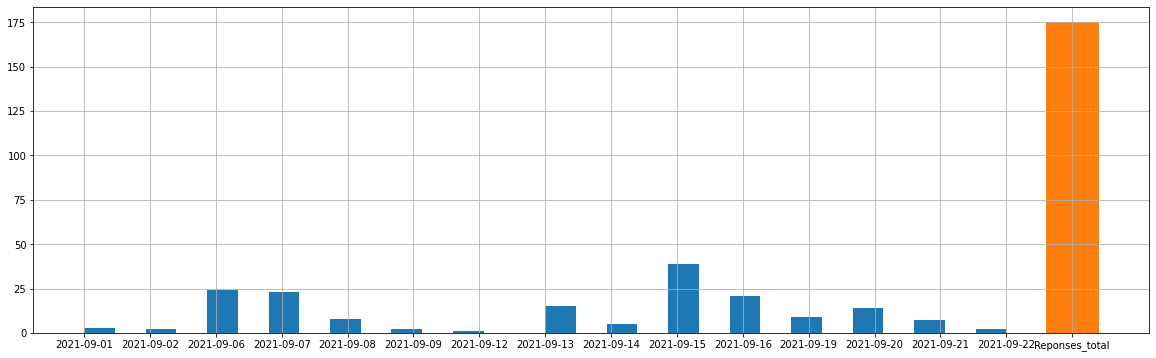

In [39]:
#@title **Recherche**
date = '2021-09-26' #@param {type:"date"}
oper = 'fin' #@param ["depot","fin"]

if oper == 'depot':
  recherche = resultat.loc[resultat[oper] == date].sort_values(by=['fin'])
  recherche['fin'].hist(bins=20,figsize=(20,6))
  nbr_att= recherche.loc[recherche['fin'].isnull()].shape[0]
  Nbr_demandes=recherche.shape[0]
  plt.bar('En_Attente',nbr_att,color='C1')
  plt.bar('Nbr_demandes',Nbr_demandes,color='C2')
  #plt.ylim([0,300])
else:
  recherche = resultat.loc[resultat[oper] == date].sort_values(by=['depot'])
  recherche['depot'].hist(bins=30,figsize=(20,6))
  nbr_tot= recherche.shape[0]
  plt.bar('Reponses_total',nbr_tot,color='C1')
  #plt.ylim([0,300])
